<a href="https://colab.research.google.com/github/maki8maki/GCI2023Winter/blob/main/competition1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pycaret

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = "/content/drive/My Drive/Colab Notebooks/GCI2023Winter/competition1/"

df = pd.read_csv(path + 'data/train.csv')
df_test = pd.read_csv(path + 'data/test.csv')

以下のサイトを参考にした

https://qiita.com/jun40vn/items/d8a1f71fae680589e05c

# EDA

In [ ]:
df.head()

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df.isnull().sum()

PassengerId      0
Perished         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

<Axes: xlabel='Cabin_label', ylabel='Perished'>

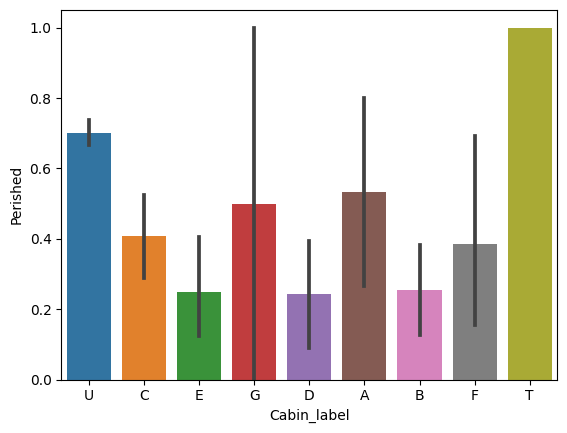

In [8]:
# Cabinについて
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0) # 先頭の文字が同じ＝船室が近いと判断
sns.barplot(x='Cabin_label', y='Perished', data=df)

# Unnownの生存率が低い

<Axes: xlabel='Embarked', ylabel='count'>

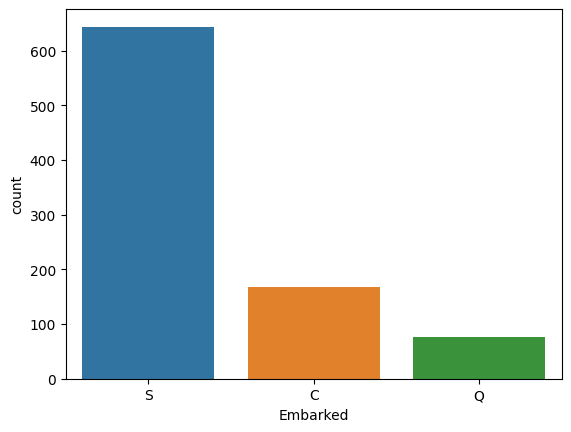

In [ ]:
sns.countplot(x='Embarked',data=df)

# 欠損値はSで埋める

<Axes: xlabel='Title', ylabel='Perished'>

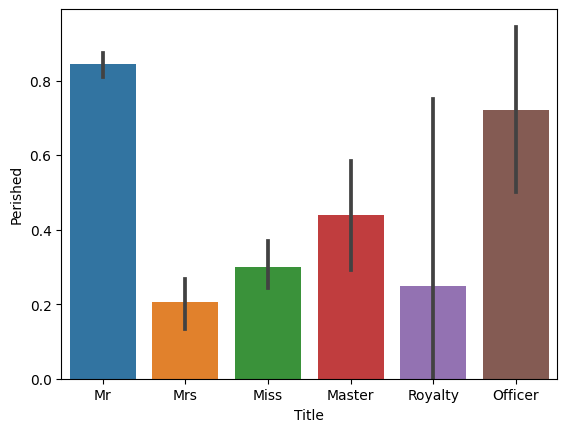

In [7]:
# 名前から敬称を取り出し，グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Perished', data=df)

<Axes: xlabel='TicketGroup', ylabel='Perished'>

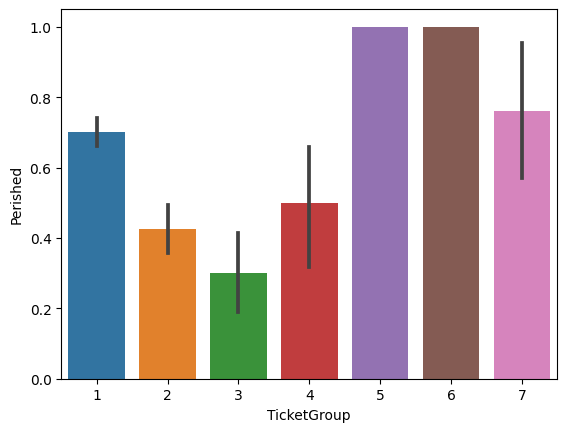

In [6]:
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Perished', data=df)

# Ageの欠損値補完の検討

In [4]:
from pycaret import regression
df = pd.read_csv(path + 'data/train.csv')
df['Family'] = df['SibSp'] + df['Parch']
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
age_df = df[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Family']]

known_age = age_df[age_df['Age'].notnull()]

exp_age = regression.setup(known_age, target='Age', session_id=0, normalize=True)

,Description,Value
0,Session id,0
1,Target,Age
2,Target type,Regression
3,Original data shape,"(714, 6)"
4,Transformed data shape,"(714, 6)"
5,Transformed train set shape,"(499, 6)"
6,Transformed test set shape,"(215, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [5]:
regression.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,9.5709,150.4427,12.1329,0.2713,0.5711,0.8765,0.0980
ada,AdaBoost Regressor,9.8432,150.9488,12.2026,0.2645,0.5913,1.0021,0.0660
lightgbm,Light Gradient Boosting Machine,9.7517,155.2557,12.3156,0.2502,0.5800,0.8939,0.2640
rf,Random Forest Regressor,9.8840,161.8238,12.5846,0.2156,0.5966,0.8972,0.3150
et,Extra Trees Regressor,10.0350,168.1111,12.8425,0.1828,0.6328,0.9214,0.2320
knn,K Neighbors Regressor,10.1809,168.8220,12.8433,0.1806,0.5833,0.8596,0.0510
xgboost,Extreme Gradient Boosting,10.0697,169.5004,12.8965,0.1739,0.6333,0.9212,0.0540
br,Bayesian Ridge,10.1678,168.5499,12.9249,0.1721,0.6253,1.1238,0.0280
dt,Decision Tree Regressor,10.0401,169.6632,12.9068,0.1720,0.6335,0.9164,0.0380
lr,Linear Regression,10.1364,168.5909,12.9257,0.1720,0.6258,1.1201,1.3210


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

GradientBoostingRegressor(random_state=0)

In [6]:
gbr = regression.create_model('gbr')
tuned_gbr = regression.tune_model(gbr, n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.4957,145.5034,12.0625,0.2107,0.5541,0.6910
1,7.0867,76.2440,8.7318,0.5247,0.3741,0.4024
2,11.9874,232.8806,15.2604,0.0448,0.6601,1.1982
3,8.5378,120.4999,10.9772,0.4066,0.5797,0.8938
4,8.6924,107.1736,10.3525,0.3236,0.6431,1.4373
5,9.1795,147.6871,12.1527,0.3039,0.6047,1.0442
6,10.4802,170.1584,13.0445,0.2904,0.6476,1.0936
7,9.6066,152.1924,12.3366,0.2841,0.4901,0.5273
8,10.8090,210.1055,14.4950,0.2064,0.5681,0.7535


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:45:26
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,9.2787,133.4418,11.5517,0.2761,0.5590,0.7196
1,7.1814,78.1928,8.8427,0.5126,0.3813,0.4130
2,12.0987,236.9376,15.3928,0.0282,0.6644,1.2070
3,8.3663,115.3562,10.7404,0.4320,0.5703,0.8864
4,8.2721,97.2206,9.8601,0.3865,0.6076,1.2670
5,9.2386,144.9014,12.0375,0.3171,0.5702,0.8735
6,10.7290,175.0709,13.2314,0.2699,0.6577,1.1277
7,9.6894,152.1399,12.3345,0.2844,0.4942,0.5346
8,10.3876,198.3048,14.0821,0.2510,0.5087,0.6556


In [7]:
final_gbr = regression.finalize_model(tuned_gbr)

# モデル選択

## ベースライン

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv(path + 'data/train.csv')
df_test = pd.read_csv(path + 'data/test.csv')

df['Age'].fillna(df['Age'].mean(), inplace=True)
df_test['Age'].fillna(df['Age'].mean(), inplace=True)

df['Fare'].fillna(df['Fare'].mean(), inplace=True)
df_test['Fare'].fillna(df['Fare'].mean(), inplace=True)

df.drop('Cabin', axis=1, inplace=True)
df_test.drop('Cabin', axis=1, inplace=True)

df['Embarked'].fillna('S', inplace=True)
df_test['Embarked'].fillna('S', inplace=True)

df.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)
df_test.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
df_test.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

df['Family'] = df['SibSp'] + df['Parch']
df_test['Family'] = df_test['SibSp'] + df_test['Parch']

df = pd.get_dummies(df)
df_test = pd.get_dummies(df_test)

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
X_test = df_test.iloc[:, :].values

param_grid = {'max_depth': [3, 5, 7],
              'min_samples_leaf': [1, 2, 4]}
rfc_gs = GridSearchCV(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), param_grid, cv=5)
rfc_gs.fit(X, y)
print('Best Parameters: {}'.format(rfc_gs.best_params_))
print('CV Score: {}'.format(round(rfc_gs.best_score_, 3)))

Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1}
CV Score: 0.826


# 提出用処理

## データの前処理

In [8]:
from pycaret import regression
from sklearn.preprocessing import StandardScaler

df_train = pd.read_csv(path + 'data/train.csv')
df_test = pd.read_csv(path + 'data/test.csv')
df_test['Perished'] = np.nan
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)
train_size = df_train.shape[0]

# Embarkedは最頻値で補完
df['Embarked'].fillna('S', inplace=True)

# 家族の数を新たに追加
df['Family'] = df['SibSp'] + df['Parch']

# 名前から敬称を取り出し，グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)

# 性別の数値化
df.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

# Cabinの欠損値補完と1文字目の取り出し
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0) # 先頭の文字が同じ＝同じグループと判断

# Fareの欠損値を Embarked='S', Pclass=3 の平均値で補完
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)

# 同じチケットの人数を利用（人数は訓練データからのみ得る）
Ticket_Count = dict(df.iloc[:train_size]['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)

# 使わない特徴量の削除
drop_list = ['Cabin', 'Name', 'PassengerId', 'Ticket']
df.drop(drop_list, axis=1, inplace=True)

# Ageの欠損値補完
age_df = df[['Age', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Family']]
unknown_age = age_df[age_df['Age'].isnull()].drop(['Age'], axis=1)
predicted_age = regression.predict_model(final_gbr, data=unknown_age)
df.loc[(df['Age'].isnull()), 'Age'] = predicted_age.loc[:, 'prediction_label']

# カテゴリカル変数をone-hot表現にする
df['Pclass'] = df['Pclass'].astype(object) # Pclassもダミー変数化する
df = pd.get_dummies(df)

# 数値データの正規化
sc = StandardScaler()
sc_list = ['Age', 'Fare', 'SibSp', 'Parch', 'Family', 'TicketGroup']
sc.fit(df.loc[:train_size, sc_list])
df.loc[:, sc_list] = sc.transform(df.loc[:, sc_list])

print(df.columns)
df.head()

Index(['Perished', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Family',
       'TicketGroup', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_label_A',
       'Cabin_label_B', 'Cabin_label_C', 'Cabin_label_D', 'Cabin_label_E',
       'Cabin_label_F', 'Cabin_label_G', 'Cabin_label_T', 'Cabin_label_U'],
      dtype='object')


,Perished,Sex,Age,SibSp,Parch,Fare,Family,TicketGroup,Pclass_1,Pclass_2,...,Title_Royalty,Cabin_label_A,Cabin_label_B,Cabin_label_C,Cabin_label_D,Cabin_label_E,Cabin_label_F,Cabin_label_G,Cabin_label_T,Cabin_label_U
0,1.0,0,-0.561512,0.433514,-0.473348,-0.502109,0.059812,-0.579162,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,1,0.626375,0.433514,-0.473348,0.787731,0.059812,-0.579162,1,0,...,0,0,0,1,0,0,0,0,0,0
2,0.0,1,-0.264540,-0.474219,-0.473348,-0.488512,-0.560561,-0.579162,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,1,0.403646,0.433514,-0.473348,0.421460,0.059812,0.155928,1,0,...,0,0,0,1,0,0,0,0,0,0
4,1.0,0,0.403646,-0.474219,-0.473348,-0.485994,-0.560561,-0.579162,0,0,...,0,0,0,0,0,0,0,0,0,1


## 推定

In [14]:
from pycaret import classification
train = df.iloc[:train_size]
test = df.iloc[train_size:].drop('Perished', axis=1)

exp_perished = classification.setup(train, target='Perished', session_id=0, feature_selection=True, n_features_to_select=20,
                                    feature_selection_method='univariate')

,Description,Value
0,Session id,0
1,Target,Perished
2,Target type,Binary
3,Original data shape,"(891, 29)"
4,Transformed data shape,"(891, 21)"
5,Transformed train set shape,"(623, 21)"
6,Transformed test set shape,"(268, 21)"
7,Numeric features,28
8,Preprocess,True
9,Imputation type,simple


In [15]:
classification.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8249,0.8655,0.8853,0.8409,0.8618,0.6231,0.6267,0.1280
ridge,Ridge Classifier,0.8217,0.0000,0.8773,0.8407,0.8580,0.6183,0.6209,0.0500
lda,Linear Discriminant Analysis,0.8201,0.8589,0.8773,0.8382,0.8567,0.6149,0.6179,0.0370
lr,Logistic Regression,0.8185,0.8596,0.8592,0.8486,0.8532,0.6151,0.6167,0.4790
lightgbm,Light Gradient Boosting Machine,0.8153,0.8696,0.8724,0.8362,0.8534,0.6040,0.6066,0.7010
ada,Ada Boost Classifier,0.8058,0.8539,0.8411,0.8458,0.8426,0.5887,0.5908,0.1890
xgboost,Extreme Gradient Boosting,0.7993,0.8571,0.8464,0.8322,0.8383,0.5734,0.5757,0.0800
knn,K Neighbors Classifier,0.7929,0.8488,0.8828,0.8035,0.8403,0.5471,0.5552,0.0710
rf,Random Forest Classifier,0.7897,0.8562,0.8465,0.8198,0.8321,0.5506,0.5533,0.3950
nb,Naive Bayes,0.7833,0.8263,0.8334,0.8218,0.8250,0.5387,0.5436,0.0550


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [16]:
gbc = classification.create_model('gbc')
tuned_gbc = classification.tune_model(gbc, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8259,0.8974,0.7778,0.8333,0.5051,0.5168
1,0.8889,0.8873,0.9231,0.9000,0.9114,0.7625,0.7630
2,0.8730,0.9701,0.8718,0.9189,0.8947,0.7350,0.7366
3,0.8387,0.9069,0.8974,0.8537,0.8750,0.6481,0.6497
4,0.8710,0.8728,0.9474,0.8571,0.9000,0.7195,0.7266
5,0.8226,0.8772,0.9211,0.8140,0.8642,0.6112,0.6209
6,0.7903,0.8103,0.8684,0.8049,0.8354,0.5477,0.5507
7,0.7581,0.7988,0.8158,0.7949,0.8052,0.4862,0.4865
8,0.8548,0.8569,0.8947,0.8718,0.8831,0.6917,0.6921


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:00:01
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Classifier


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8082,0.8974,0.7955,0.8434,0.5442,0.5528
1,0.8571,0.8926,0.8974,0.8750,0.8861,0.6947,0.6951
2,0.8889,0.9583,0.8718,0.9444,0.9067,0.7700,0.7737
3,0.8387,0.8958,0.8718,0.8718,0.8718,0.6544,0.6544
4,0.8871,0.9035,0.9474,0.8780,0.9114,0.7565,0.7606
5,0.8387,0.8728,0.9474,0.8182,0.8780,0.6437,0.6589
6,0.7903,0.8081,0.8684,0.8049,0.8354,0.5477,0.5507
7,0.7581,0.8355,0.8158,0.7949,0.8052,0.4862,0.4865
8,0.8548,0.8427,0.8947,0.8718,0.8831,0.6917,0.6921


In [18]:
lgbm = classification.create_model('lightgbm')
tuned_lgbm = classification.tune_model(lgbm, n_iter=100)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8243,0.8718,0.7907,0.8293,0.5132,0.5183
1,0.8571,0.8868,0.8974,0.8750,0.8861,0.6947,0.6951
2,0.8571,0.9637,0.8718,0.8947,0.8831,0.6995,0.6999
3,0.7903,0.8679,0.8462,0.8250,0.8354,0.5467,0.5470
4,0.8710,0.9079,0.9474,0.8571,0.9000,0.7195,0.7266
5,0.8226,0.8377,0.8947,0.8293,0.8608,0.6173,0.6207
6,0.7581,0.8344,0.8158,0.7949,0.8052,0.4862,0.4865
7,0.8065,0.8355,0.8684,0.8250,0.8462,0.5857,0.5871
8,0.8065,0.8657,0.8158,0.8611,0.8378,0.5983,0.5996


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:05:59
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7937,0.8360,0.8974,0.7955,0.8434,0.5442,0.5528
1,0.8889,0.8932,0.9231,0.9000,0.9114,0.7625,0.7630
2,0.8889,0.9701,0.8462,0.9706,0.9041,0.7735,0.7838
3,0.8226,0.8857,0.8974,0.8333,0.8642,0.6094,0.6129
4,0.8710,0.8673,0.9474,0.8571,0.9000,0.7195,0.7266
5,0.8387,0.8640,0.9474,0.8182,0.8780,0.6437,0.6589
6,0.8065,0.8322,0.8947,0.8095,0.8500,0.5792,0.5850
7,0.8065,0.8311,0.8684,0.8250,0.8462,0.5857,0.5871
8,0.8226,0.8624,0.8684,0.8462,0.8571,0.6232,0.6236


In [19]:
final_lgbm = classification.finalize_model(tuned_lgbm)
pred = classification.predict_model(final_lgbm, data=test).loc[:, 'prediction_label'].values
pred[:5]

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


array([1, 1, 1, 1, 0])

In [20]:
submission = pd.read_csv(path + 'gender_submission.csv')
submission

,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [21]:
submission['Perished'] = pred
submission.iloc[:9]

,PassengerId,Perished
0,892,1
1,893,1
2,894,1
3,895,1
4,896,0
5,897,1
6,898,1
7,899,1
8,900,0


In [22]:
submission.to_csv(path+'submission.csv', index=False)